# Dataset anlysis

## Bibliotecas

In [309]:
import os
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import numpy as np
import cv2

### Variables globales

In [310]:
# Dataset original
ruta_imagenes = "./Dataset/Whole_AnimalTrack/frames_all"
ruta_anotaciones = "./Dataset/Whole_AnimalTrack/gt_all"

# Subset
subset_imagenes = "./Dataset/Subset_AnimalTrack/frames_all"
subset_anotaciones = "./Dataset/Subset_AnimalTrack/gt_all"

# Conjuntos de entrenamiento y test
ruta_train = "./Dataset/train_test_splits/gt_train.txt"
ruta_test = "./Dataset/train_test_splits/gt_test.txt"


## Visualizar datos (dataset completo)

### Número de imágenes por categoría

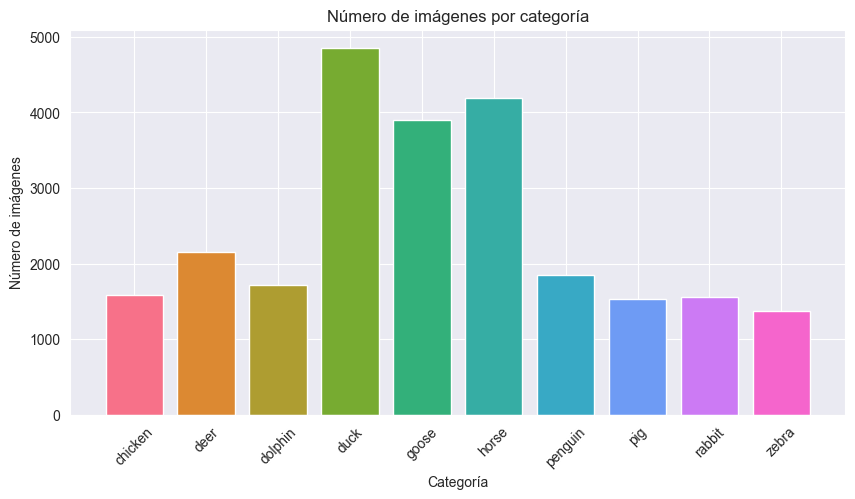

In [311]:
def contar_imagenes_por_categoria(rutal):
    categorias = defaultdict(int)
    patron = re.compile(r"([a-zA-Z]+)_\d+")

    for subcarpeta in os.listdir(rutal):
        match = patron.match(subcarpeta)
        if match:
            categoria = match.group(1)
            ruta_subcarpeta = os.path.join(rutal, subcarpeta)
            if os.path.isdir(ruta_subcarpeta):
                imagenes = [
                    f
                    for f in os.listdir(ruta_subcarpeta)
                    if f.lower().endswith((".jpg"))
                ]
                categorias[categoria] += len(imagenes)

    return categorias


def graficar_categorias(categorias):
    sns.set_style("darkgrid")
    colores = sns.color_palette("husl", len(categorias))
    plt.figure(figsize=(10, 5))
    plt.bar(categorias.keys(), categorias.values(), color=colores)
    plt.xlabel("Categoría")
    plt.ylabel("Número de imágenes")
    plt.title("Número de imágenes por categoría")
    plt.xticks(rotation=45)
    plt.show()


categorias = contar_imagenes_por_categoria(ruta_imagenes)

graficar_categorias(categorias)


### Número de imágenes por vídeo

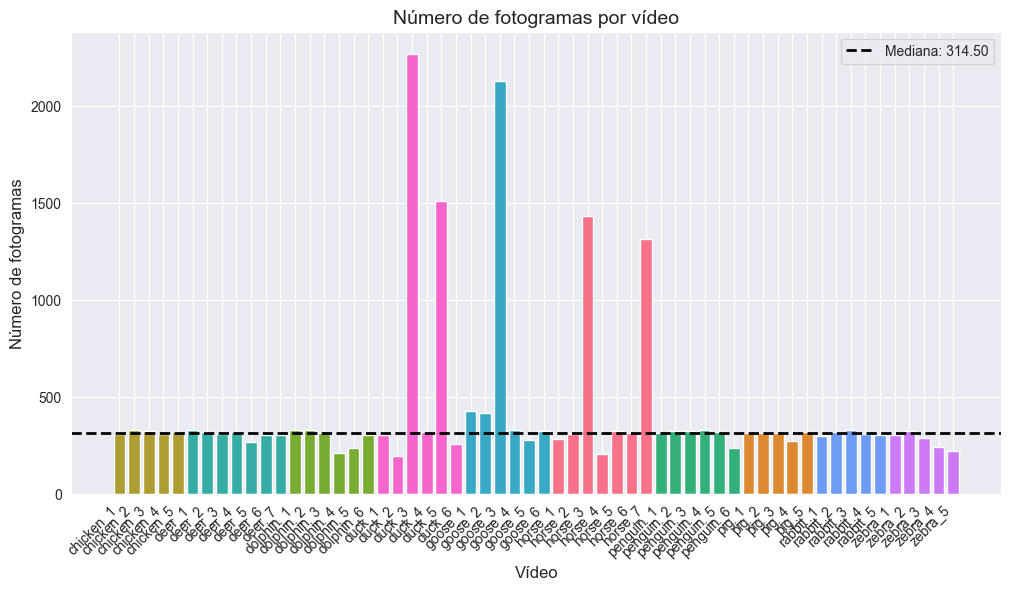

In [312]:
def contar_fotogramas_por_video(ruta_principal):
    conteo_subcarpetas = {}
    categoria_colores = {}
    patron = re.compile(r"([a-zA-Z]+)_\d+")

    categorias_unicas = set()
    for subcarpeta in os.listdir(ruta_principal):
        match = patron.match(subcarpeta)
        if match:
            categorias_unicas.add(match.group(1))

    paleta_colores = sns.color_palette("husl", len(categorias_unicas))
    categoria_colores = {
        cat: paleta_colores[i] for i, cat in enumerate(categorias_unicas)
    }

    for subcarpeta in os.listdir(ruta_principal):
        match = patron.match(subcarpeta)
        if match:
            categoria = match.group(1)
            ruta_subcarpeta = os.path.join(ruta_principal, subcarpeta)
            if os.path.isdir(ruta_subcarpeta):
                imagenes = [
                    f
                    for f in os.listdir(ruta_subcarpeta)
                    if f.lower().endswith((".jpg"))
                ]
                conteo_subcarpetas[subcarpeta] = (
                    len(imagenes),
                    categoria_colores[categoria],
                )

    return conteo_subcarpetas


def graficar_subcarpetas(conteo_subcarpetas):
    subcarpetas = list(conteo_subcarpetas.keys())
    cantidades = [conteo_subcarpetas[sub][0] for sub in subcarpetas]
    colores = [conteo_subcarpetas[sub][1] for sub in subcarpetas]

    mediana = np.median(cantidades)

    sns.set_style("darkgrid")
    plt.figure(figsize=(12, 6))
    plt.bar(subcarpetas, cantidades, color=colores)
    plt.axhline(
        y=mediana,
        color="black",
        linestyle="dashed",
        linewidth=2,
        label=f"Mediana: {mediana:.2f}",
    )

    plt.xlabel("Vídeo", fontsize=12)
    plt.ylabel("Número de fotogramas", fontsize=12)
    plt.title("Número de fotogramas por vídeo", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.show()


conteo_subcarpetas = contar_fotogramas_por_video(ruta_imagenes)

graficar_subcarpetas(conteo_subcarpetas)


### Número de detecciones por categoría

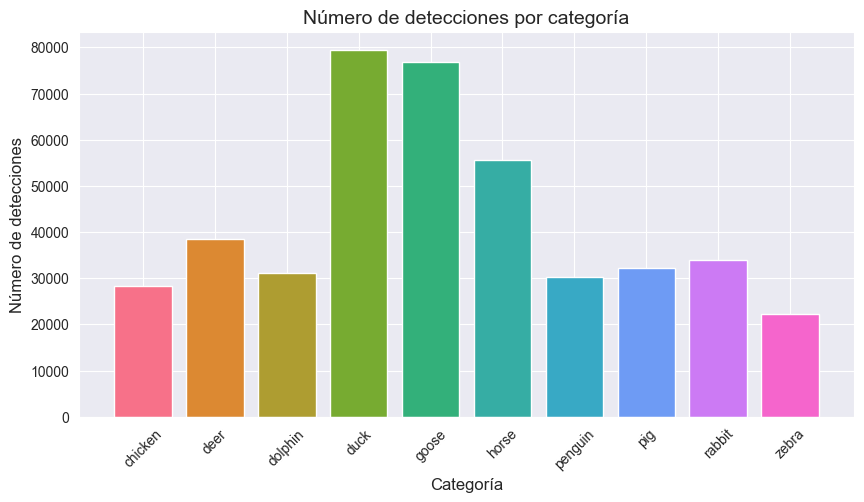

In [313]:
def contar_detecciones_por_categoria(ruta_txt):
    detecciones = defaultdict(int)
    patron = re.compile(r"([a-zA-Z]+)_\d+_gt\.txt")

    for archivo in os.listdir(ruta_txt):
        if archivo.endswith("_gt.txt"):
            match = patron.match(archivo)
            if match:
                categoria = match.group(1)
                with open(os.path.join(ruta_txt, archivo), "r") as f:
                    for linea in f:
                        datos = linea.strip().split(",")
                        if len(datos) >= 8:
                            detecciones[categoria] += 1

    return detecciones


def graficar_detecciones(detecciones):
    sns.set_style("darkgrid")
    colores = sns.color_palette("husl", len(detecciones))

    plt.figure(figsize=(10, 5))
    plt.bar(detecciones.keys(), detecciones.values(), color=colores)
    plt.xlabel("Categoría", fontsize=12)
    plt.ylabel("Número de detecciones", fontsize=12)
    plt.title("Número de detecciones por categoría", fontsize=14)
    plt.xticks(rotation=45)
    plt.show()


detecciones = contar_detecciones_por_categoria(ruta_anotaciones)

graficar_detecciones(detecciones)


### Ejemplos de imágenes con las bounding boxes

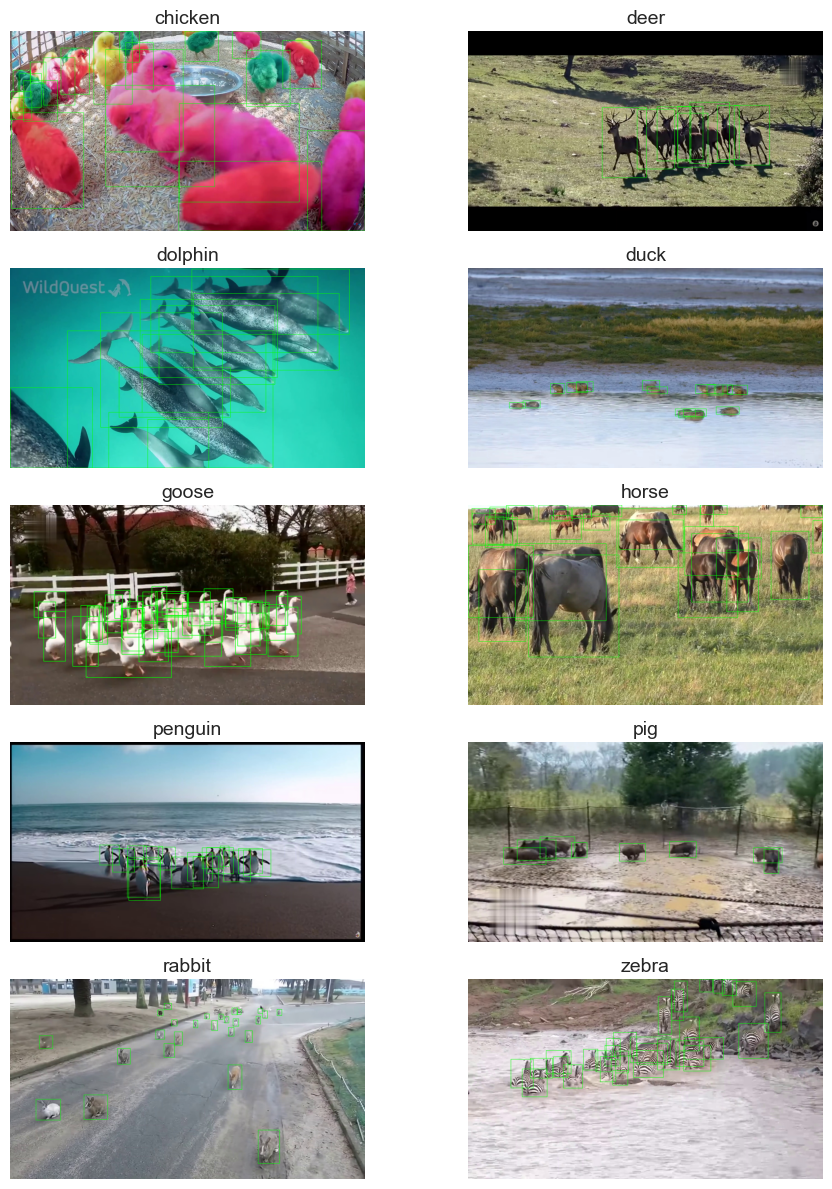

In [314]:
def cargar_imagenes_con_detecciones(ruta_imagenes, ruta_anotaciones):
    imagenes_categoria = defaultdict(list)

    carpeta_1 = [
        carpeta for carpeta in os.listdir(ruta_imagenes) if carpeta.endswith("_1")
    ]

    for carpeta in carpeta_1:
        carpeta_path = os.path.join(ruta_imagenes, carpeta)
        if os.path.isdir(carpeta_path):
            imagenes = os.listdir(carpeta_path)[0]

            archivo_gt = os.path.join(ruta_anotaciones, f"{carpeta}_gt.txt")
            if os.path.exists(archivo_gt):
                with open(archivo_gt, "r") as f:
                    frame_detecciones = defaultdict(list)
                    for linea in f:
                        datos = linea.strip().split(",")
                        if len(datos) >= 8:
                            frame_id = int(datos[0])
                            if frame_id != 1:
                                break
                            bbox = [
                                int(datos[2]),
                                int(datos[3]),
                                int(datos[4]),
                                int(datos[5]),
                            ]
                            frame_detecciones[frame_id].append(bbox)

                    for frame_id, bboxes in frame_detecciones.items():
                        imagen_nombre = f"{frame_id:04d}.jpg"
                        if imagen_nombre in imagenes:
                            imagen_path = os.path.join(carpeta_path, imagen_nombre)
                            imagenes_categoria[carpeta].append((imagen_path, bboxes))

    imagenes_con_bboxes = {}
    for categoria, imagenes in imagenes_categoria.items():
        if imagenes:
            imagenes_con_bboxes[categoria] = imagenes[0]

    return imagenes_con_bboxes


def dibujar_bboxes(imagen_path, bboxes):
    imagen = cv2.imread(imagen_path)
    for bbox in bboxes:
        top_left = (bbox[0], bbox[1])
        bottom_right = (bbox[0] + bbox[2], bbox[1] + bbox[3])
        cv2.rectangle(imagen, top_left, bottom_right, (0, 255, 0), 2)

    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    return imagen_rgb


def mostrar_imagenes_con_bboxes(imagenes_con_bboxes, filas, columnas):
    fig, axes = plt.subplots(filas, columnas, figsize=(10, 12))

    axes = axes.flatten()

    for i, (categoria, (imagen_path, bboxes)) in enumerate(imagenes_con_bboxes.items()):
        ax = axes[i]
        imagen_con_bboxes = dibujar_bboxes(imagen_path, bboxes)
        ax.imshow(imagen_con_bboxes)

        cat = categoria.split("_")[0]
        ax.set_title(f"{cat}", fontsize=14)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


imagenes_con_bboxes = cargar_imagenes_con_detecciones(ruta_imagenes, ruta_anotaciones)
mostrar_imagenes_con_bboxes(imagenes_con_bboxes, filas=5, columnas=2)


### Número de fotogramas de entrenamiento por categoría

In [315]:
def subset_imagenes_por_categoria(ruta_imagenes, ruta_subset, filtro_categorias):
    categorias = defaultdict(int)
    patron = re.compile(r"([a-zA-Z]+)_\d+")

    with open(ruta_subset, 'r') as f:
        lineas = f.readlines()

    categorias_train = [linea.strip().split("_g")[0] for linea in lineas]

    conjunto = []
    for subcarpeta in os.listdir(ruta_imagenes):
        if subcarpeta in categorias_train:
            categoria = subcarpeta.split("_")[0]
            
            if categoria in filtro_categorias:
                conjunto.append(subcarpeta)
                ruta_subcarpeta = os.path.join(ruta_imagenes, subcarpeta)
                
                if os.path.isdir(ruta_subcarpeta):
                    imagenes = [
                        f
                        for f in os.listdir(ruta_subcarpeta)
                        if f.lower().endswith((".jpg"))
                    ]
                    categorias[categoria] += len(imagenes)

    print("Subset")
    print(conjunto)
    return categorias

def graficar_subset(categorias, titulo):
    sns.set_style("darkgrid")
    colores = sns.color_palette("husl", len(categorias))
    plt.figure(figsize=(10, 5))
    plt.bar(categorias.keys(), categorias.values(), color=colores)
    plt.xlabel("Categoría")
    plt.ylabel("Número de imágenes")
    plt.title(titulo)
    plt.show()

def obtener_categorias_unicas(ruta_imagenes):
    categorias = set()
    
    for subcarpeta in os.listdir(ruta_imagenes):
        if os.path.isdir(os.path.join(ruta_imagenes, subcarpeta)):
            categoria = subcarpeta.split("_")[0]
            categorias.add(categoria)
    
    return list(categorias)


Subset
['chicken_3', 'chicken_4', 'chicken_5', 'deer_4', 'deer_5', 'deer_6', 'deer_7', 'dolphin_4', 'dolphin_5', 'dolphin_6', 'duck_4', 'duck_5', 'duck_6', 'goose_4', 'goose_5', 'goose_6', 'horse_4', 'horse_5', 'horse_6', 'horse_7', 'penguin_4', 'penguin_5', 'penguin_6', 'pig_3', 'pig_4', 'pig_5', 'rabbit_3', 'rabbit_4', 'rabbit_5', 'zebra_3', 'zebra_4', 'zebra_5']


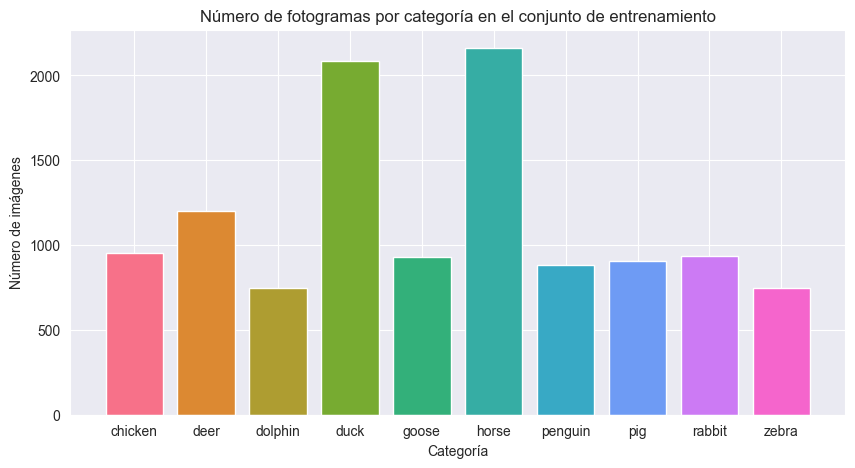

In [316]:
filtro_categorias = obtener_categorias_unicas(ruta_imagenes)

categorias = subset_imagenes_por_categoria(ruta_imagenes, ruta_train, filtro_categorias)

graficar_subset(categorias, "Número de fotogramas por categoría en el conjunto de entrenamiento")

### Número de fotogramas de prueba por categoría

Subset
['chicken_1', 'chicken_2', 'deer_1', 'deer_2', 'deer_3', 'dolphin_1', 'dolphin_2', 'dolphin_3', 'duck_1', 'duck_2', 'duck_3', 'goose_1', 'goose_2', 'goose_3', 'horse_1', 'horse_2', 'horse_3', 'penguin_1', 'penguin_2', 'penguin_3', 'pig_1', 'pig_2', 'rabbit_1', 'rabbit_2', 'zebra_1', 'zebra_2']


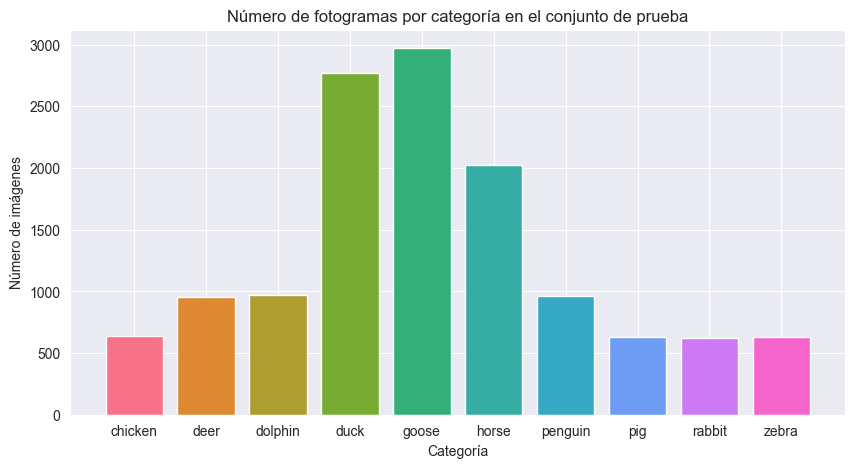

In [317]:
categorias = subset_imagenes_por_categoria(ruta_imagenes, ruta_test, filtro_categorias)

graficar_subset(categorias, "Número de fotogramas por categoría en el conjunto de prueba")

## Visualizar datos (dataset reducido)

### Número de imágenes por categoría

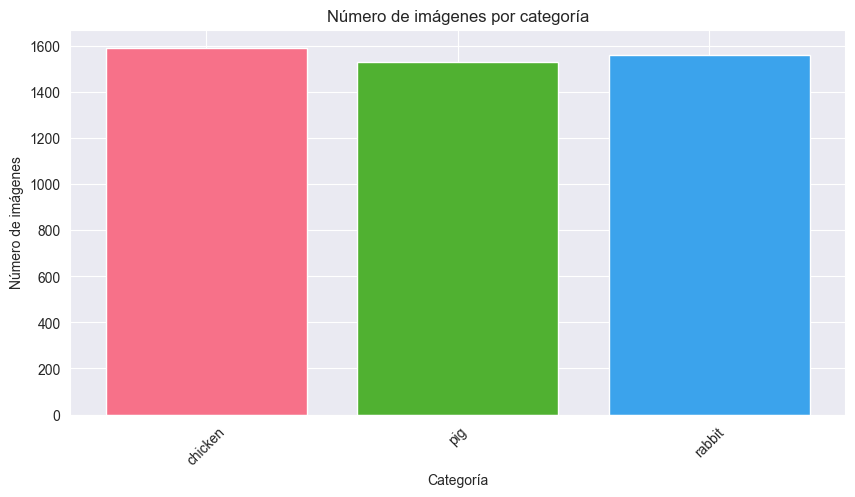

In [318]:
categorias = contar_imagenes_por_categoria(subset_imagenes)

graficar_categorias(categorias)


### Número de imágenes por vídeo

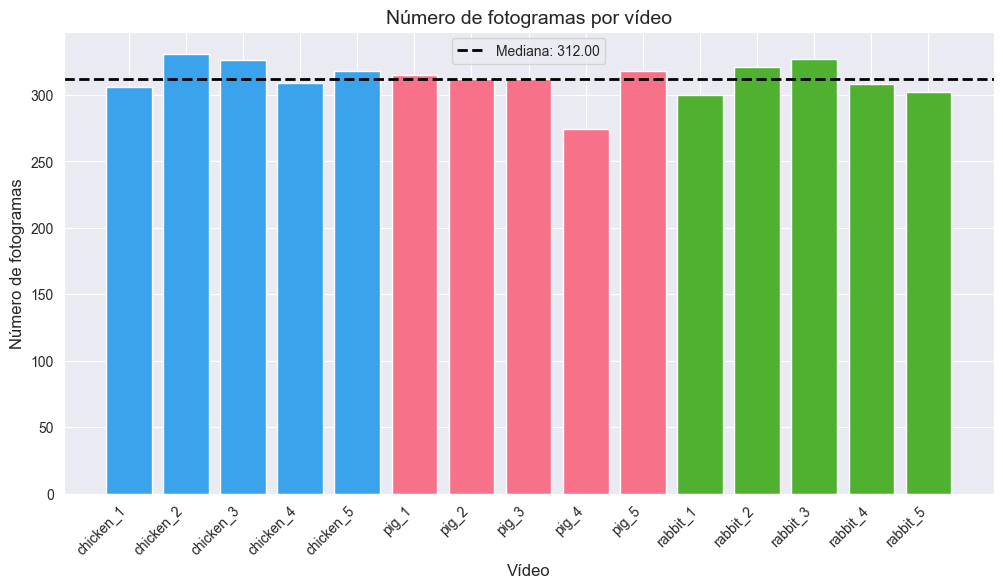

In [319]:
conteo_subcarpetas = contar_fotogramas_por_video(subset_imagenes)

graficar_subcarpetas(conteo_subcarpetas)

### Número de detecciones por categoría

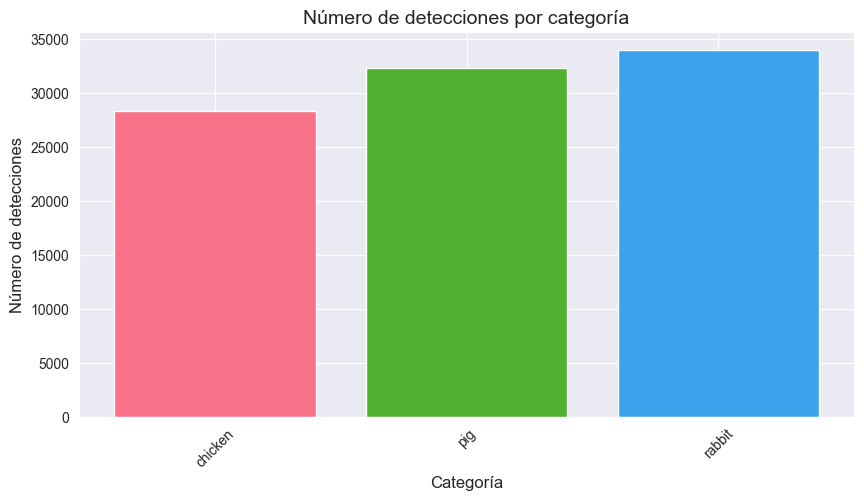

In [320]:
detecciones = contar_detecciones_por_categoria(subset_anotaciones)

graficar_detecciones(detecciones)

### Ejemplos de imágenes con las bounding boxes

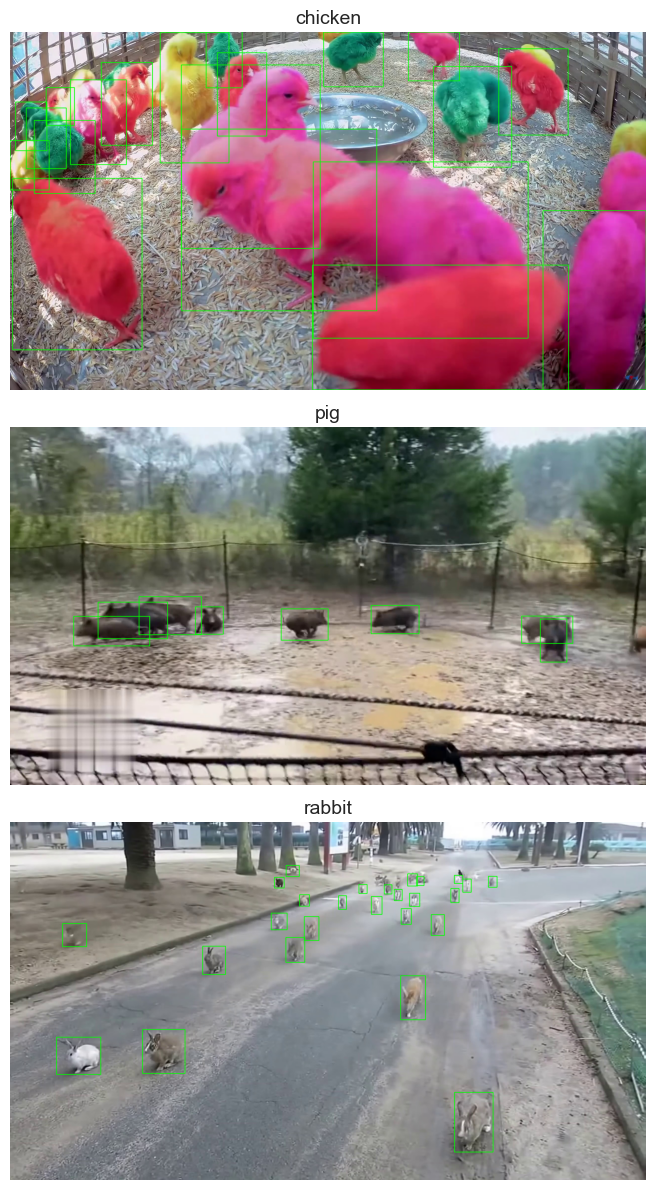

In [321]:
imagenes_con_bboxes = cargar_imagenes_con_detecciones(
    subset_imagenes, subset_anotaciones
)
mostrar_imagenes_con_bboxes(imagenes_con_bboxes, filas=3, columnas=1)


### Número de fotogramas de entrenamiento por categoría

Subset
['chicken_3', 'chicken_4', 'chicken_5', 'pig_3', 'pig_4', 'pig_5', 'rabbit_3', 'rabbit_4', 'rabbit_5']


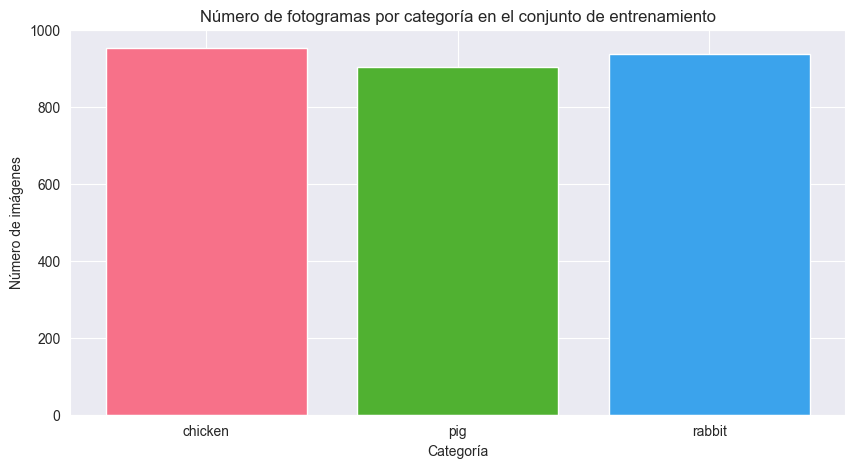

In [322]:
filtro_categorias = obtener_categorias_unicas(subset_imagenes)

categorias = subset_imagenes_por_categoria(subset_imagenes, ruta_train, filtro_categorias)

graficar_subset(categorias, "Número de fotogramas por categoría en el conjunto de entrenamiento")

Subset
['chicken_1', 'chicken_2', 'pig_1', 'pig_2', 'rabbit_1', 'rabbit_2']


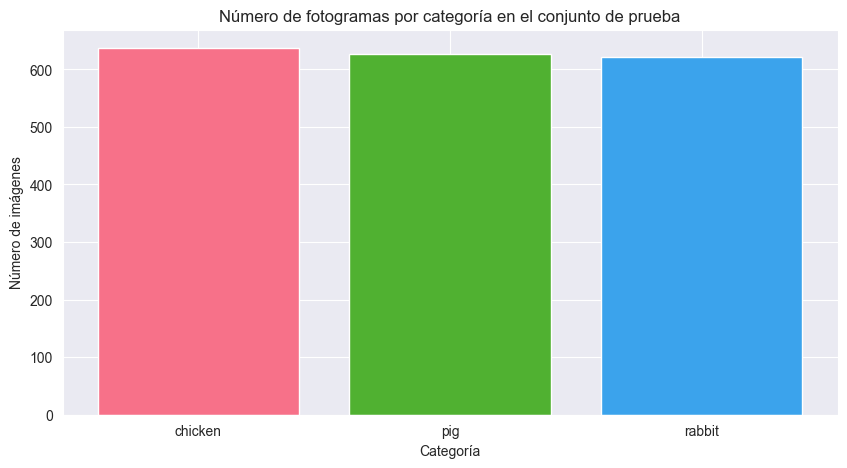

In [323]:
categorias = subset_imagenes_por_categoria(subset_imagenes, ruta_test, filtro_categorias)

graficar_subset(categorias, "Número de fotogramas por categoría en el conjunto de prueba")